# RBF Networks 2

In this notebook, radial basis networks are again used to approximate sin functions, but this time we train them on noisy input data and verify that they still properly generalize. The performance of these RBF networks is also compared to the performance of similar multi layer perceptrons.

In [1]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)

from ann.plotting import figsize, subplots
from ann.rbf_network import *

Using Theano backend.


# Create (Noisy) Input Functions

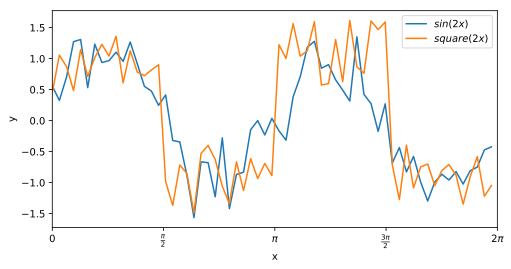

In [2]:
dataset_sin, dataset_square = create_test_dataset(noise_variance=0.1)

plt.savefig('../figures/rbf_noisy_sin_square.svg')

# Residual Error for Varying Number of Units and RBF Width

## Least Squares

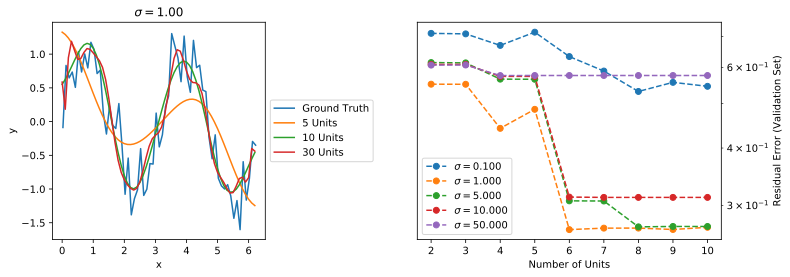

In [3]:
profile_networks(dataset_sin,
                 nodes_profile=range(2, 11),
                 nodes_preview=[5, 10, 30],
                 kwargs_network={'node_std': [0.1, 1, 5, 10, 50]},
                 kwargs_training={'training': 'least_squares'})

plt.savefig('../figures/rbf_number_width_noisy_sin_lst.svg')

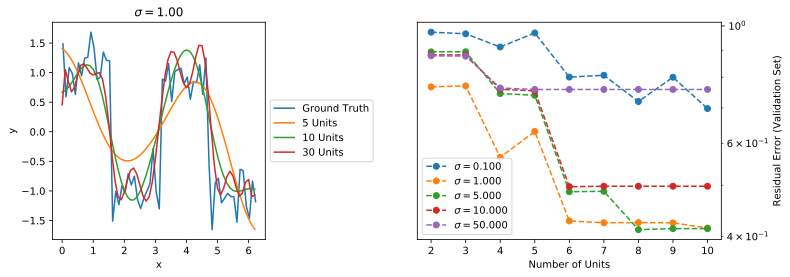

In [4]:
profile_networks(dataset_square,
                 nodes_profile=range(2, 11),
                 nodes_preview=[5, 10, 30],
                 kwargs_network={'node_std': [0.1, 1, 5, 10, 50]},
                 kwargs_training={'training': 'least_squares'})

plt.savefig('../figures/rbf_number_width_noisy_square_lst.svg')

## Delta Rule

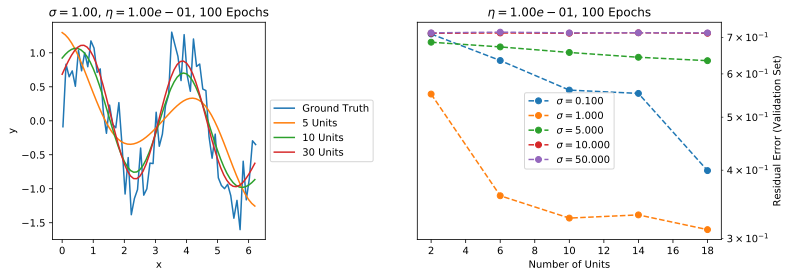

In [5]:
profile_networks(dataset_sin,
                 nodes_profile=range(2, 21, 4),
                 nodes_preview=[5, 10, 30],
                 kwargs_network={'node_std': [0.1, 1, 5, 10, 50]},
                 kwargs_training={'training': 'delta_rule'})

plt.savefig('../figures/rbf_number_width_noisy_square_delta.svg')

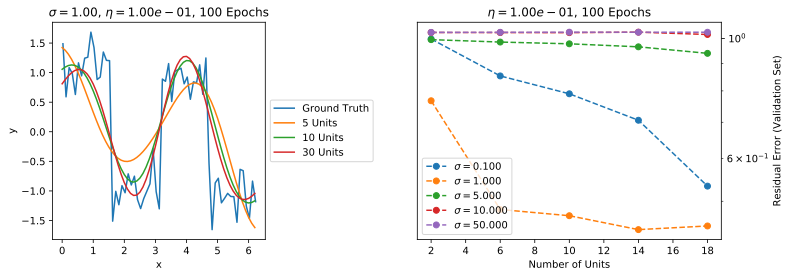

In [6]:
profile_networks(dataset_square,
                 nodes_profile=range(2, 21, 4),
                 nodes_preview=[5, 10, 30],
                 kwargs_network={'node_std': [0.1, 1, 5, 10, 50]},
                 kwargs_training={'training': 'delta_rule'})

plt.savefig('../figures/rbf_number_width_noisy_square_delta.svg')

# Convergence

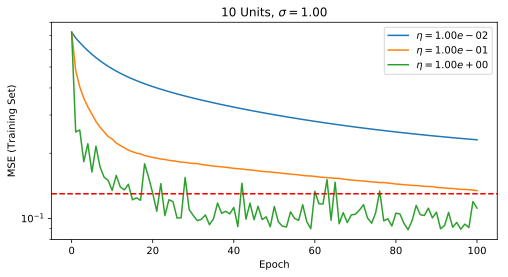

In [7]:
profile_convergence(dataset_sin,
                    kwargs_training={'learning_rate': [0.01, 0.1, 1]},
                    thresh=[0.13])

plt.savefig('../figures/rbf_convergence_sin.svg')

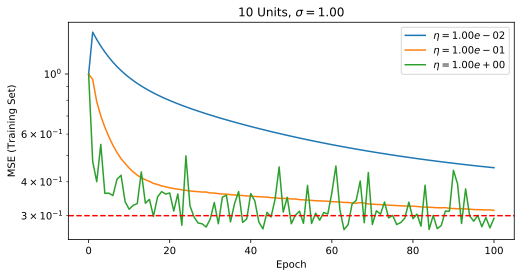

In [8]:
profile_convergence(dataset_square,
                    kwargs_training={'learning_rate': [0.01, 0.1, 1]},
                    thresh=[0.3])

plt.savefig('../figures/rbf_convergence_square.svg')

# Effect of Modifying RBF widths

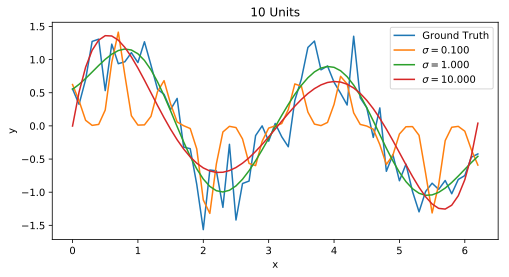

In [9]:
profile_rbf_widths(dataset_sin,
                   kwargs_network={'node_std': [0.1, 1, 10]})

plt.savefig('../figures/rbf_width.svg')

# Random Node Positioning

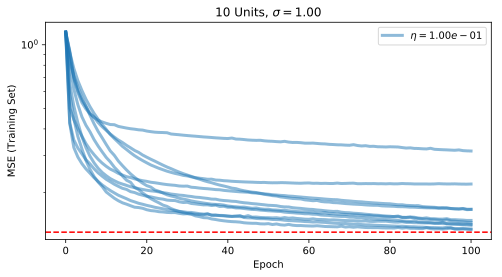

In [10]:
profile_convergence(dataset_sin,
                    kwargs_network={'node_pos': 'random'},
                    kwargs_training={'learning_rate': [0.1]},
                    thresh=[0.13],
                    runs=10)

plt.savefig('../figures/rbf_random_learning_curves_sin.svg')

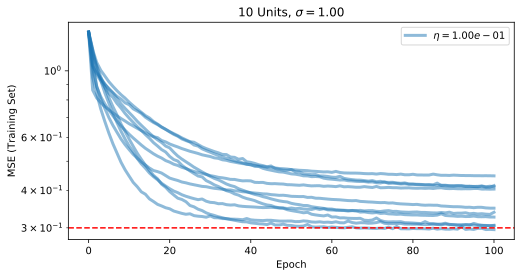

In [11]:
profile_convergence(dataset_square,
                    kwargs_network={'node_pos': 'random'},
                    kwargs_training={'learning_rate': [0.1]},
                    thresh=[0.3],
                    runs=10)

plt.savefig('../figures/rbf_random_learning_curves_square.svg')

In [12]:
def rbf_equal_vs_random(dataset, runs=100):
    fmt = "Using least squares fitting, {} units, sigma = {}"
    print(fmt.format(DEFAULT_NODES, DEFAULT_NODE_STD))

    # equal spacing
    model = GaussianRBFNetwork(domain=dataset.x)

    model.least_squares_fit(dataset.x, dataset.y)

    y_pred = model.predict(dataset.x_test)
    error_equal = np.mean((y_pred - dataset.y_test)**2)

    fmt = "MSE for equally spaced units is {:1.3e}"
    print(fmt.format(error_equal))

    # random positioning
    errors_random = []
    for _ in range(runs):
        model = GaussianRBFNetwork(domain=dataset.x, node_pos='random')

        model.least_squares_fit(dataset.x, dataset.y)

        y_pred = model.predict(dataset.x_test)
        errors_random.append(np.mean((y_pred - dataset.y_test)**2))

    fmt = "MSE for random unit positions is {:1.3e} +/- {:1.3e}"
    print(fmt.format(np.mean(errors_random), np.std(errors_random)))

In [13]:
rbf_equal_vs_random(dataset_sin)

Using least squares fitting, 10 units, sigma = 1
MSE for equally spaced units is 1.296e-01
MSE for random unit positions is 1.298e-01 +/- 1.599e-03


In [14]:
rbf_equal_vs_random(dataset_square)

Using least squares fitting, 10 units, sigma = 1
MSE for equally spaced units is 2.962e-01
MSE for random unit positions is 3.012e-01 +/- 7.498e-03


# Performance on Clean Data

In [15]:
dataset_sin_clean, dataset_square_clean = create_test_dataset(show=False)

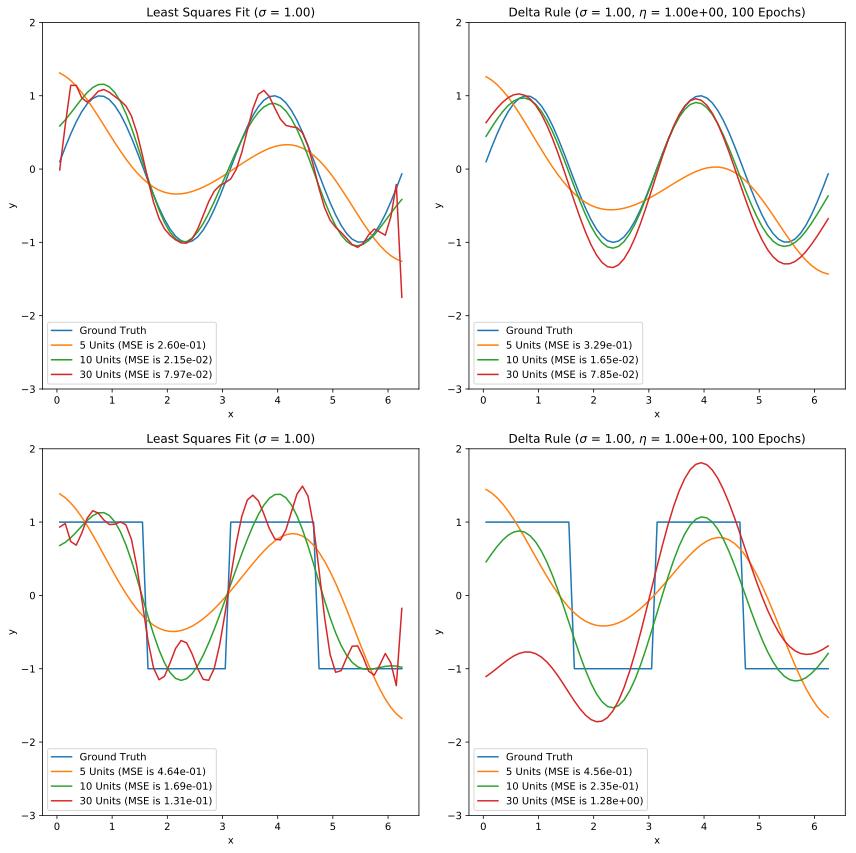

In [16]:
profile_clean_performance(datasets_noisy=[dataset_sin, dataset_square],
                          datasets_clean=[dataset_sin_clean, dataset_square_clean],
                          kwargs_network={'nodes': [[5, 10, 30], [5, 10, 30]]},
                          kwargs_training={'learning_rate': 1})

plt.tight_layout()

plt.savefig('../figures/rbf_clean_data_performance.svg')

# Find Optimal RBF Network and Compare with Perceptron

## Sin

In [17]:
nodes, node_std, res_min = rbf_network_gridsearch(
    dataset_sin,
    kwargs_network={
        'nodes': range(2, 11),
        'node_std': np.arange(0.1, 10, 0.1)}
)

fmt = "Best RBF network has {} units with standard deviation {:1.2f} (and residual {:1.2e})"
print(fmt.format(nodes, node_std, res_min))

Best RBF network has 6 units with standard deviation 1.20 (and residual 2.64e-01)


RBF training ran in 4.17e-02 +/- 4.57e-03 seconds
Perceptron training ran in 4.34e-01 +/- 4.25e-01 seconds
RBF MSE is 1.279e-01 +/- 0.000e+00
Perceptron MSE is 1.568e-01 +/- 2.876e-02


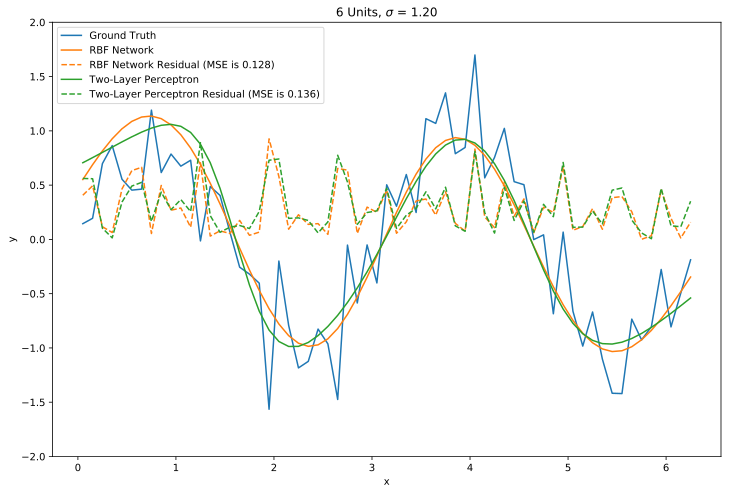

In [18]:
rbf_perceptron_compare(dataset_sin,
                       rbf_nodes=6,
                       rbf_node_std=1.2,
                       perceptron_nodes=6,
                       perceptron_learning_rate=0.1,
                       perceptron_momentum=0.9,
                       perceptron_epochs=1000)

plt.savefig('../figures/rbf_perceptron_compare_sin.svg')

## Square

In [19]:
nodes, node_std, res_min = rbf_network_gridsearch(
    dataset_square,
    kwargs_network={
        'nodes': range(2, 11),
        'node_std': np.arange(0.1, 10, 0.1)}
)

fmt = "Best RBF network has {} units with standard deviation {:1.2f} (and residual {:1.2e})"
print(fmt.format(nodes, node_std, res_min))

Best RBF network has 8 units with standard deviation 0.30 (and residual 3.72e-01)


RBF training ran in 9.00e-02 +/- 3.90e-02 seconds
Perceptron training ran in 3.81e-01 +/- 9.77e-02 seconds
RBF MSE is 3.157e-01 +/- 0.000e+00
Perceptron MSE is 2.438e-01 +/- 4.427e-02


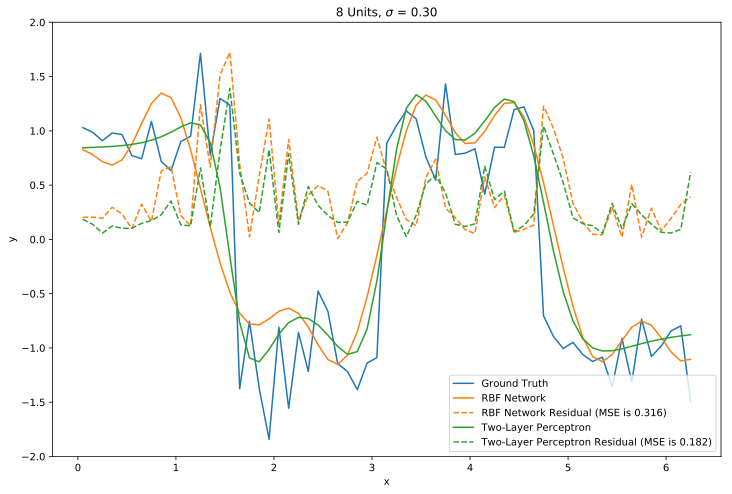

In [20]:
rbf_perceptron_compare(dataset_square,
                       rbf_nodes=8,
                       rbf_node_std=0.30,
                       perceptron_nodes=8,
                       perceptron_learning_rate=0.1,
                       perceptron_momentum=0.9,
                       perceptron_epochs=1000)

plt.savefig('../figures/rbf_perceptron_compare_square.svg')